In [4]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

<h3>Please note the the current worksheet DOES not represent my own work.</h3>

<p>
It rather serves a coding along / learing exerices so that I familiraise myself with these very useful consepts in ML / AI.
</p>


<h3>installing the right libraries might be tricky</h3>

- create a new virtual environmeng using python =3.11

<b>- conda create -n "test" python=3.11 anaconda</b>

- we define that as we need to install, afterwards, pip install skforecast (version, 0.16.0) that needs python 3.9 and above.

<b>- pip install skforecast</b>

<b>- conda install conda-forge::shap</b>



In [5]:
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

In [6]:

# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster, load_forecaster
from skforecast.metrics import calculate_coverage
from skforecast.plot import plot_prediction_intervals
import shap

In [7]:
# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.16.0
Version scikit-learn: 1.6.1
Version pandas: 2.2.3
Version numpy: 2.1.3


<h2>Data</h2>

<p></p>
A time series is available with the monthly expenditure (millions of dollars) on corticosteroid drugs that the Australian health system had between 1991 and 2008. It is intended to <b>create an autoregressive model capable of predicting future monthly expenditures</b>. The data used in the examples of this document have been obtained from the magnificent book Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos.
</p>


[Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/transformations.html)


In [8]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True)

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


In [9]:
data.describe()

,y,exog_1,exog_2
count,195.000000,195.000000,195.000000
mean,0.782026,1.272981,1.478472
std,0.219447,0.148954,0.178951
min,0.361801,0.949715,1.067942
25%,0.599634,1.156923,1.353336
50%,0.761822,1.292393,1.463507
75%,0.950712,1.396324,1.599487
max,1.257238,1.534778,1.891882


In [14]:
# Explore the Columns of the data set.

data.columns

Index(['fecha', 'y', 'exog_1', 'exog_2'], dtype='object')

The column date has been stored as a string. To convert it to datetime the pd.to_datetime() function can be use. Once in datetime format, and to make use of Pandas functionalities, it is set as an index. 

Also, since the data is monthly, the frequency is set as Monthly Started 'MS'.

In [10]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
#data = data.asfreq('MS')
#data = data.sort_index()
#data.head()

In [16]:
#data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


In [11]:
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


When using the asfreq() method in Pandas, any gaps in the time series will be filled with NaN values to match the specified frequency. Therefore, it is essential to check for any missing values that may occur after this transformation.

In [18]:
# Missing values
# ==============================================================================
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


<h3>verify that the time series is complete.</h3>

Although it is unnecessary, since a frequency has been established, it is possible to verify that the time series is complete.

In [19]:
# Verify that a temporary index is complete
# ==============================================================================
start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

Index complete: True


<H2>The last 36 months are used as the test set to evaluate the predictive capacity of the model.</h2>

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


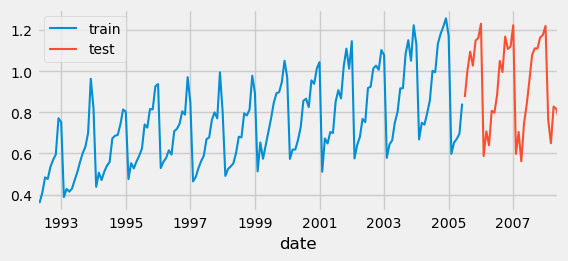

In [16]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

<h3>Recursive multi-step forecasting</h3>

<p>
With the ForecasterRecursive class, a forecasting model is created and trained using a <b>RandomForestRegressor</b> regressor with a <b>time window of 6 lags</b>. This means that the model uses the previous 6 months as predictors.</p>

In [21]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data_train['y'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1 2 3 4 5 6] 
Window features: None 
Window size: 6 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-17 18:10:48 
Last fit date: 2025-05-17 18:10:48 
Skforecast version: 0.16.0 
Python version: 3.11.11 
Forecaster id: None

<h2>Prediction</h2>

<p>
Once the model is trained, the test data is predicted (36 months into the future).</p>

In [22]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

In [27]:
# figure(figsize=(WIDTH_SIZE,HEIGHT_SIZE))

#fig(fig=(16,8))


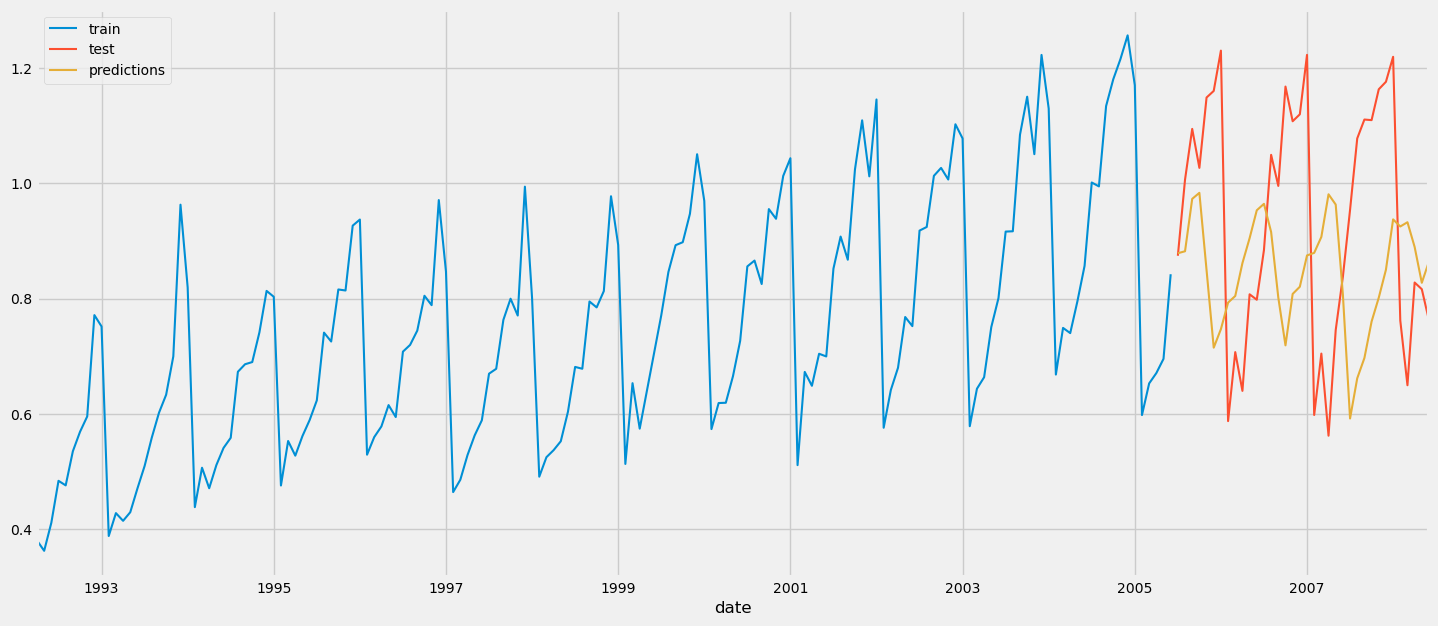

In [28]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 7))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

<h3>Forecasting error in the test set</h3>

<p>To quantify the error the model makes in its predictions, the mean squared error (mse) metric is used.</p>

In [29]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.07326833976120374


<h2>Hyperparameter tuning</h2>

<p>
The trained ForecasterRecursive uses a 6 lags as predictors and a Random Forest model with the default hyperparameters.</p> 
<p>However, there is no reason why these values are the most suitable. <b>Skforecast provide several search strategies to find the best combination</b> of hyperparameters and lags. In this case, the grid_search_forecaster function is used. It compares the results obtained with each combinations of hyperparameters and lags, and identify the best one.</p>

The computational cost of hyperparameter tuning depends heavily on the backtesting approach chosen to evaluate each hyperparameter combination. In general, the duration of the tuning process increases with the number of re-trains involved in the backtesting.

To effectively speed up the prototyping phase, it is highly recommended to adopt a two-step strategy. First, use refit=False during the initial search to narrow down the range of values. 

Then, focus on the identified region of interest and apply a tailored backtesting strategy that meets the specific requirements of the use case. For more tips on backtesting strategies, see Hyperparameter tuning and lags selection. 

see here!
[hyperparameter tuning](https://skforecast.org/0.16.0/user_guides/hyperparameter-tuning-and-lags-selection.html#)


In [27]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Training and validation folds
cv = TimeSeriesFold(
      steps              = 36,
      initial_train_size = int(len(data_train) * 0.5),
      refit              = False,
      fixed_train_size   = False,

    )

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 0.02177319540541341


In [32]:
#cv.split(X=data, as_pandas=True)

In [26]:
#initial_train_size

int(len(data_train) * 0.5)
#len(data_train['y'])

79

In [42]:
# Search results
# ==============================================================================
results_grid#['lags_label]

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

results_grid['lags_label']
results_grid


,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 250}",0.021773,3,250
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 250}",0.022068,8,250
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.022569,3,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 100}",0.023562,8,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.063144,3,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 250}",0.064241,3,250
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'n_estimators': 250}",0.064546,8,250
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'n_estimators': 100}",0.068730,8,100


<h2>Final model</h2>

<p>
Finally, a ForecasterRecursive is trained with the optimal configuration found. This step is not necessary if return_bestis set to True in the grid_search_forecaster function.
</p>


In [29]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = RandomForestRegressor(n_estimators=250, max_depth=3, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 20
             )
forecaster.fit(y=data_train['y'])

In [30]:
steps

36

In [44]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

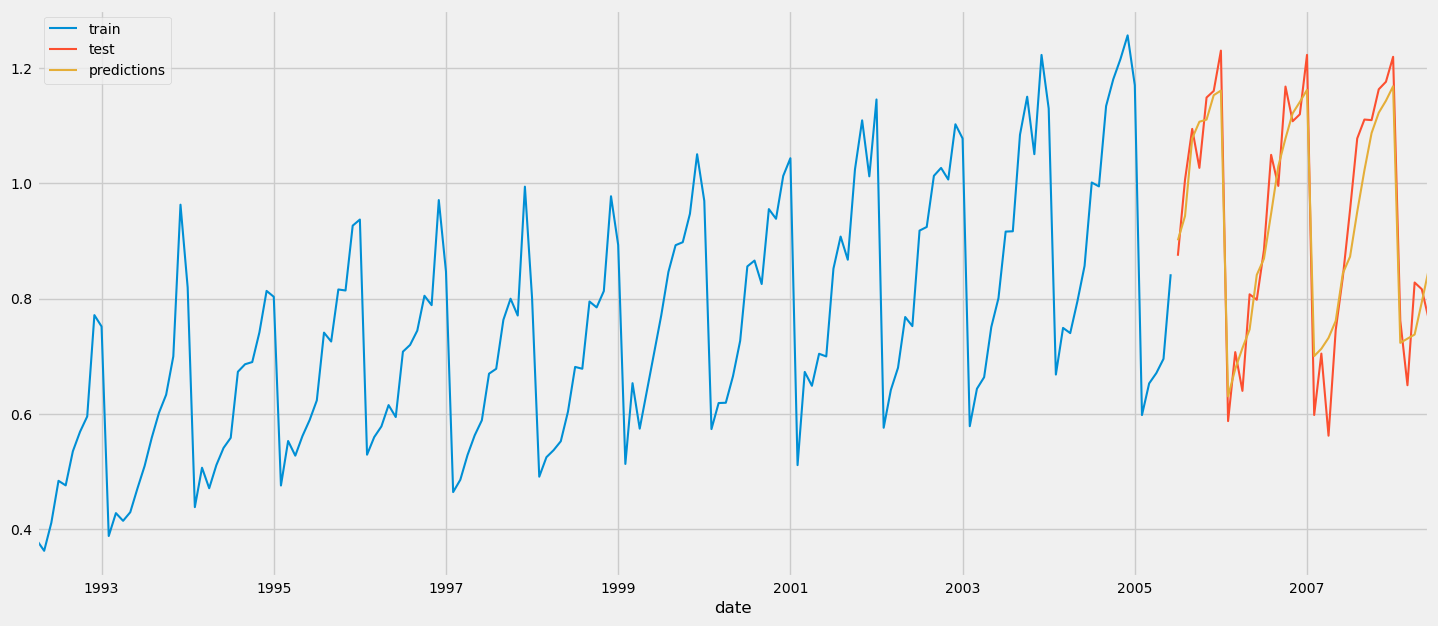

In [46]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 7))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [33]:
#cv.split(X=data, as_pandas=True)

<h2>note: Do not confuse the lags with steps!</h2>

<p>
With the ForecasterRecursive class, a forecasting model is created and trained using a <b>RandomForestRegressor</b> regressor with a <b>time window of 6 lags</b>. This means that the model uses the previous 6 months as predictors.</p>


<p>Whereas the step variable is used to split the data into training an testing ...!</p>

<b>
<code>
Split data into train-test
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
</b>
</code>


In [47]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.004356831371529945


<h2>Backtesting</h2>

<p>
To obtain a robust estimate of the model's predictive capacity, a backtesting process is carried out. The process of backtesting consists of evaluating the performance of a predictive model by applying it retrospectively to historical data. Therefore, it is a special type of cross-validation applied to the previous period(s).
</p>

<b>
✎ Note
</b>


<p>
To ensure an accurate evaluation of your model and gain confidence in its predictive performance on new data, it is critical to employ an appropriate backtesting strategy. Factors such as use case characteristics, available computing resources and time intervals between predictions need to be considered to determine which strategy to use.
</p>

<p>
In general, the more closely the backtesting process resembles the actual scenario in which the model is used, the more reliable the estimated metric will be. For more information about backtesting, visit Which strategy should I use?.
</p>


<h2>
Backtesting with refit and increasing training size (fixed origin)
</h2>

<p>
The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.</p>

In [13]:
# Backtesting partitions using TimeSeriesFold
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 12 * 3, 
         initial_train_size = len(data) - 12 * 9,  # Last 9 years are separated for the backtest
         window_size        = 20,
         fixed_train_size   = False,
         refit              = True,
     )

cv.split(X=data, as_pandas=True)

Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



,fold,train_start,train_end,last_window_start,last_window_end,test_start,test_end,test_start_with_gap,test_end_with_gap,fit_forecaster
0,0,0,87,67,87,87,123,87,123,True
1,1,0,123,103,123,123,159,123,159,True
2,2,0,159,139,159,159,195,159,195,True


When used in combination with backtesting_forecaster, the window_size argument does not need to be specified. This is because backtesting_forecaster automatically sets this value based on the forecaster's configuration. This ensures that the backtesting process is perfectly aligned with the forecaster's requirements.

In [18]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    cv         = cv,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                )
metric

Information of folds
--------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

,mean_squared_error
0,0.010233


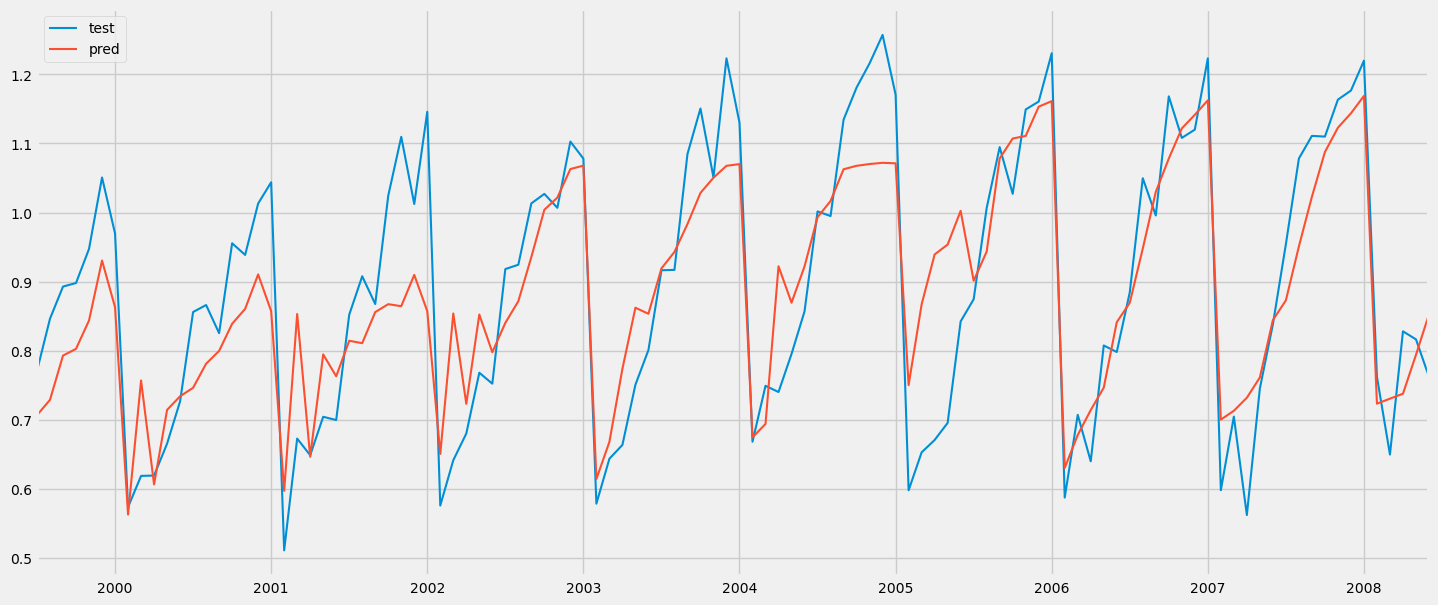

In [19]:
# Plot backtest predictions vs real values
# ==============================================================================
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 7))
data.loc[predictions_backtest.index, 'y'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

<h2>Model explanaibility (Feature importance)</h2>

<p>
Due to the complex nature of many modern machine learning models, such as ensemble methods, they often function as black boxes, making it difficult to understand why a particular prediction was made. Explanability techniques aim to demystify these models, providing insight into their inner workings and helping to build trust, improve transparency, and meet regulatory requirements in various domains. Enhancing model explainability not only helps to understand model behavior, but also helps to identify biases, improve model performance, and enable stakeholders to make more informed decisions based on machine learning insights.
</p>

<p>
Skforecast is compatible with some of the most popular model explainability methods: model-specific feature importances, SHAP values, and partial dependence plots.
</p>

Model-specific feature importance





In [34]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importances()
importance.head(15)

,feature,importance
11,lag_12,0.815564
1,lag_2,0.086286
13,lag_14,0.019047
9,lag_10,0.013819
2,lag_3,0.012943
14,lag_15,0.009637
0,lag_1,0.009141
10,lag_11,0.008130
7,lag_8,0.007377
8,lag_9,0.005268


<h2>Shap values</h2>

<p>
SHAP (SHapley Additive exPlanations) values are a popular method for explaining machine learning models, as they help to understand how variables and values influence predictions visually and quantitatively.
</p>

<p>
It is possible to generate SHAP-values explanations from skforecast models with just two essential elements:
</p>

    - The internal regressor of the forecaster.

    - The training matrices created from the time series and used to fit the forecaster.

<p>
By leveraging these two components, users can create insightful and interpretable explanations for their skforecast models. These explanations can be used to verify the reliability of the model, identify the most significant factors that contribute to model predictions, and gain a deeper understanding of the underlying relationship between the input variables and the target variable.
</p>



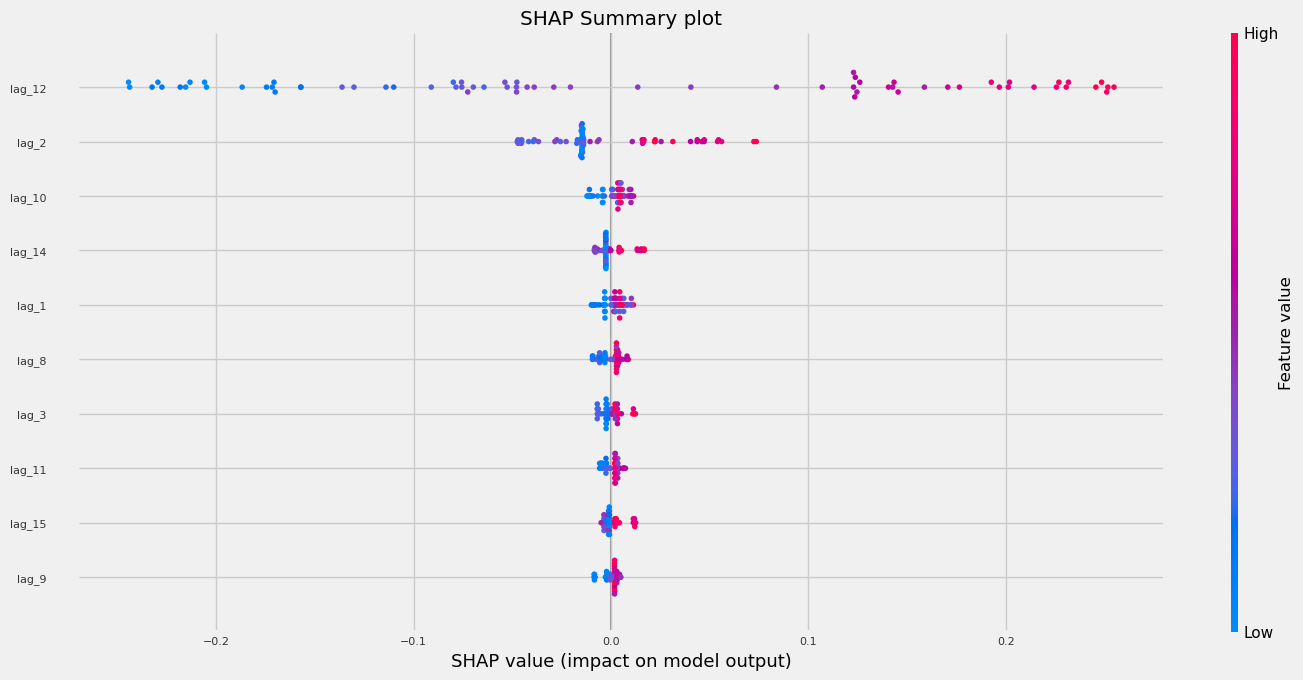

In [35]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(y=data_train['y'])

# Create SHAP explainer (for three base models)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)
# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

# Shap summary plot (top 10)
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(16, 7)

#fig, ax = plt.subplots(figsize=(16, 7))


In [36]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

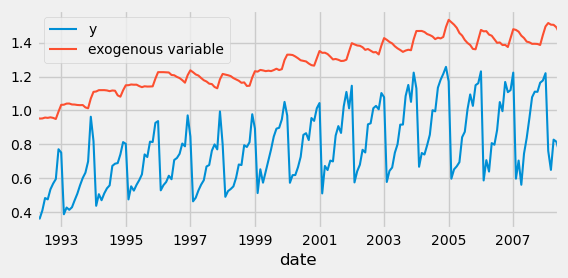

In [37]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

fig, ax = plt.subplots(figsize=(6, 2.7))
data['y'].plot(ax=ax, label='y')
data['exog_1'].plot(ax=ax, label='exogenous variable')
ax.legend(loc='upper left');

In [38]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [41]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 8
             )
forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])

In [42]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

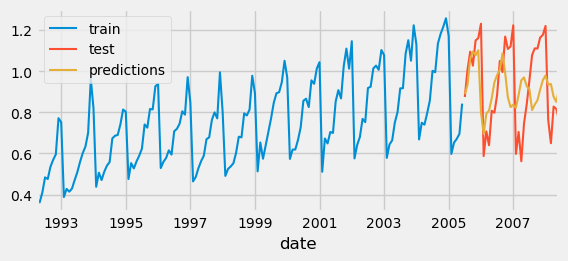

In [43]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [44]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.03989087922533575


<h2>Window and custom features</h2>

<p>
When forecasting time series data, it may be useful to consider additional characteristics beyond just the lagged values. For example, the moving average of the previous n values may help to capture the trend in the series. The window_features argument allows the inclusion of additional predictors created with the previous values of the series.
</p>

<h4>
The RollingFeatures class availabe is skforecast allows the creation of some of the most commonly used predictors:
</h4>

    -'mean': the mean of the previous n values.
    -'std': the standard deviation of the previous n values.
    -'min': the minimum of the previous n values.
    -'max': the maximum of the previous n values.
    -'sum': the sum of the previous n values.
    -'median': the median of the previous n values.
    -'ratio_min_max': the ratio between the minimum and maximum of the previous n values.
    -'coef_variation': the coefficient of variation of the previous n values.

<p>
The user can specify a different window size for each of them or the same for all of them.
</p>



In [45]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [46]:
# Window features
# ==============================================================================
window_features = RollingFeatures(
    stats = ['mean', 'std', 'min', 'max'],
    window_sizes = 20
)

In [47]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor       = RandomForestRegressor(random_state=123),
                lags            = 10,
                window_features = window_features,
             )
forecaster.fit(y=data_train['y'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window features: ['roll_mean_20', 'roll_std_20', 'roll_min_20', 'roll_max_20'] 
Window size: 20 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-17 19:45:01 
Last fit date: 2025-05-17 19:45:01 
Skforecast version: 0.16.0 
Python version: 3.11.11 
Forecaster id: None

In [48]:
# Training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(y=data_train['y'])
display(X_train.head(5))
display(y_train.head(5))

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,roll_mean_20,roll_std_20,roll_min_20,roll_max_20
date,,,,,,,,,,,,,,
1993-12-01,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.387554,0.523089,0.122733,0.361801,0.771258
1994-01-01,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.552253,0.152567,0.361801,0.963081
1994-02-01,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.575129,0.156751,0.387554,0.963081
1994-03-01,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.576486,0.155363,0.387554,0.963081
1994-04-01,0.506121,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.577622,0.154728,0.387554,0.963081


date
1993-12-01    0.963081
1994-01-01    0.819325
1994-02-01    0.437670
1994-03-01    0.506121
1994-04-01    0.470491
Freq: MS, Name: y, dtype: float64

In [49]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)

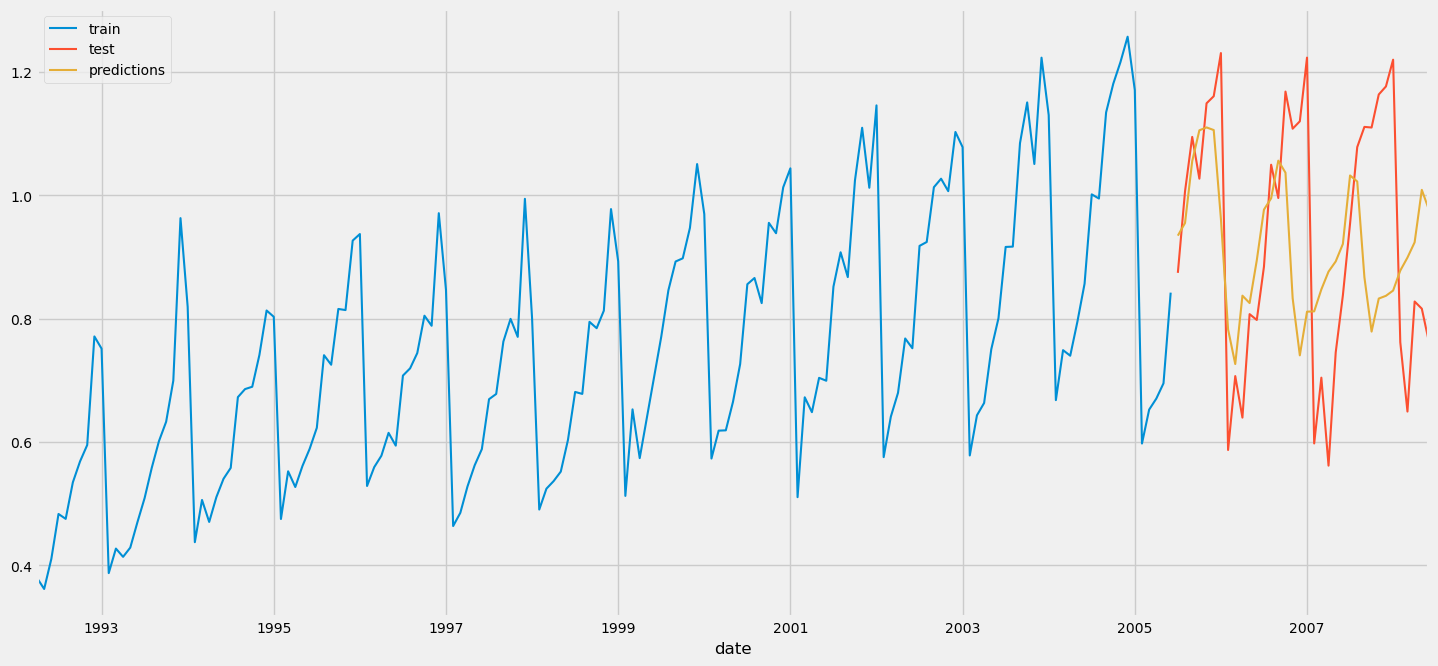

In [50]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 7.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [51]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.04180143590431811


<h2>Direct multi-step forecasting</h2>


stop here